# Propensity Score Matching 

**Goal.** Estimate the causal effect of completing more projects on job offers, adjusting for pre-treatment confounders using Propensity Score Matching (PSM).

**Setup.**
- Treatment (**D**): `Projects_Completed ≥ 3` → 1, else 0  
- Outcome (**Y**): `Job_Offers`  
- Confounders (**X**): `Internships_Completed`, `Networking_Score`, `Soft_Skills_Score` (pre-treatment; backdoor set from the DAG)

**Lifecycle.** 
- (1) Estimate propensity scores →
- (2) Match (NN + caliper; enforce common support) →
- (3) Balance checks (SMD, t-tests, Love plot) →
- (4) Outcome analysis (ATT + CI).

The effect is reported both by `CausalModel` and transparently on matched pairs.


**1. Import Libraries**

In [11]:
!pip install causalinference

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from causalinference import CausalModel           
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

**2. Load data & define variables**

In [16]:
# Load merged analysis dataset (produced earlier in the pipeline)
df = pd.read_csv(r"C:\Users\Ellen\Desktop\Documents\Part-Time work\Projects\Education & Career Success\Dataset\merged_student_data.csv")

# Binary treatment: policy cut 
df["D"] = (df["Projects_Completed"] >= 3).astype(int)

Y_col  = "Job_Offers"
X_cols = ["Internships_Completed", "Networking_Score", "Soft_Skills_Score"]  # pre-treatment only

# Keep complete cases for this analysis block
df = df.dropna(subset=["D", Y_col] + X_cols).copy()

Y = df[Y_col].values
D = df["D"].values
X = df[X_cols].values

**3. Causal estimate via matching (CausalModel)**

In [19]:
# CausalModel gives ATE/ATT/ATC with SEs/p-values using matching
cm = CausalModel(Y=Y, D=D, X=X)
cm.est_via_matching(bias_adj=True, matches=1)  # 1:1 NN; bias adjustment on
print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      2.761      0.082     33.624      0.000      2.600      2.922
           ATC      0.854      0.176      4.844      0.000      0.508      1.200
           ATT      2.810      0.083     34.011      0.000      2.648      2.972



C:\Users\Ellen\anaconda3\Lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


**Interpretation.** 

We focus on **ATT** (average treatment effect on treated): expected change in `Job_Offers` for those who completed ≥3 projects, relative to similar learners who did not, after matching on confounders.

**4. Propensity model & overlap (diagnostics)**

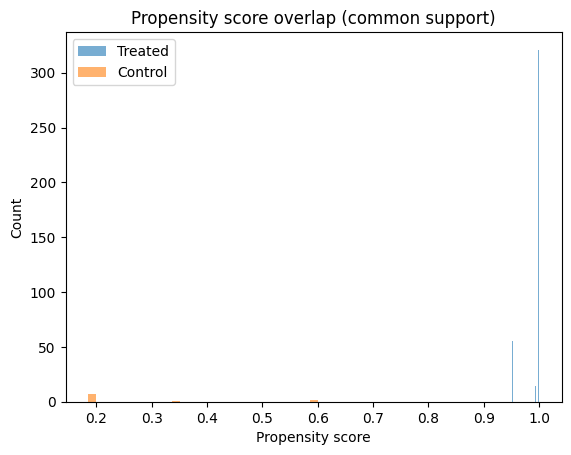

In [27]:
# Estimate propensity scores (logit of D ~ X) for diagnostics/plots
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
logit = LogisticRegression(max_iter=1000, solver="lbfgs").fit(X_std, D)
df["ps"] = logit.predict_proba(X_std)[:, 1]

# PS overlap (common support)
plt.figure()
plt.hist(df.loc[df.D==1, "ps"], bins=30, alpha=0.6, label="Treated")
plt.hist(df.loc[df.D==0, "ps"], bins=30, alpha=0.6, label="Control")
plt.title("Propensity score overlap (common support)")
plt.xlabel("Propensity score"); plt.ylabel("Count"); plt.legend(); plt.show()

# Trim to common support (optional but recommended)
lo = max(df.loc[df.D==1,"ps"].min(), df.loc[df.D==0,"ps"].min())
hi = min(df.loc[df.D==1,"ps"].max(), df.loc[df.D==0,"ps"].max())
df_cs = df[(df["ps"] >= lo) & (df["ps"] <= hi)].copy()

**Interpretation:**

- Almost all treated at ~1.0 (PS ≈ 1).
- Almost all control at low values (PS ≈ 0.2–0.3).
- Very little to no overlap.

This means logistic regression can perfectly separate treated from control; i.e., based on confounders, the model can almost always tell who is “treated.” That breaks the common support assumption and makes **PSM unreliable.**

**A few possibile reasons:**

- **Treatment coding is too strict:** If we set Projects_Completed >= 3 as treated, maybe nearly everyone qualifies, or almost no one does. We will try different thresholds (e.g. >=1, >=2, or binarize differently).

- **Strong predictors in confounders:** Maybe something like Internships_Completed is heavily correlated with Projects_Completed, so the logit pushes PS to extremes.

- **Imbalanced dataset:** If you have very few treated vs control (or vice versa), overlap can collapse.

In [32]:
# Checking treatment distribution
df["D"].value_counts(normalize=True)

D
1    0.975
0    0.025
Name: proportion, dtype: float64

In [34]:
# Inspect propensity score ranges per group
df.groupby("D")["ps"].describe()

,count,mean,std,min,25%,50%,75%,max
D,,,,,,,,
0,10.0,0.284159,0.173780,0.185143,0.185143,0.185143,0.305651,0.599883
1,390.0,0.992736,0.016877,0.951285,0.999405,0.999993,0.999999,1.000000


Because 97.5% of students completed ≥3 projects, **PSM isn’t valid; there are no comparable controls.** This demonstrates the importance of treatment definition and overlap checks in causal inference.

**Descriptive statistics for treatment, outcome, and confounders**

In [38]:
# Descriptive stats for treatment, outcome, and confounders
cols_to_check = ["Projects_Completed", "Job_Offers", 
                 "Internships_Completed", "Networking_Score", "Soft_Skills_Score"]

desc = df[cols_to_check].describe().T
desc["missing"] = df[cols_to_check].isnull().sum()
desc["unique"] = df[cols_to_check].nunique()

print("Descriptive statistics:")
display(desc)

# Quick distribution checks
for col in cols_to_check:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().sort_index().head(10))  

Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max,missing,unique
Projects_Completed,400.0,6.2350,1.902320,2.0,5.0,6.0,8.0,9.0,0,8
Job_Offers,400.0,2.7400,1.355357,0.0,2.0,3.0,4.0,5.0,0,6
Internships_Completed,400.0,2.5000,1.061988,0.0,2.0,3.0,3.0,4.0,0,5
Networking_Score,400.0,6.9325,1.318062,4.0,6.0,7.0,8.0,9.0,0,6
Soft_Skills_Score,400.0,7.9325,1.314253,5.0,7.0,8.0,9.0,10.0,0,6



Value counts for Projects_Completed:
Projects_Completed
2    10
3    31
4    37
5    60
6    70
7    83
8    49
9    60
Name: count, dtype: int64

Value counts for Job_Offers:
Job_Offers
0     10
1     69
2    107
3    101
4     55
5     58
Name: count, dtype: int64

Value counts for Internships_Completed:
Internships_Completed
0     10
1     69
2    108
3    137
4     76
Name: count, dtype: int64

Value counts for Networking_Score:
Networking_Score
4      8
5     57
6     84
7    114
8     79
9     58
Name: count, dtype: int64

Value counts for Soft_Skills_Score:
Soft_Skills_Score
5       7
6      58
7      85
8     113
9      79
10     58
Name: count, dtype: int64


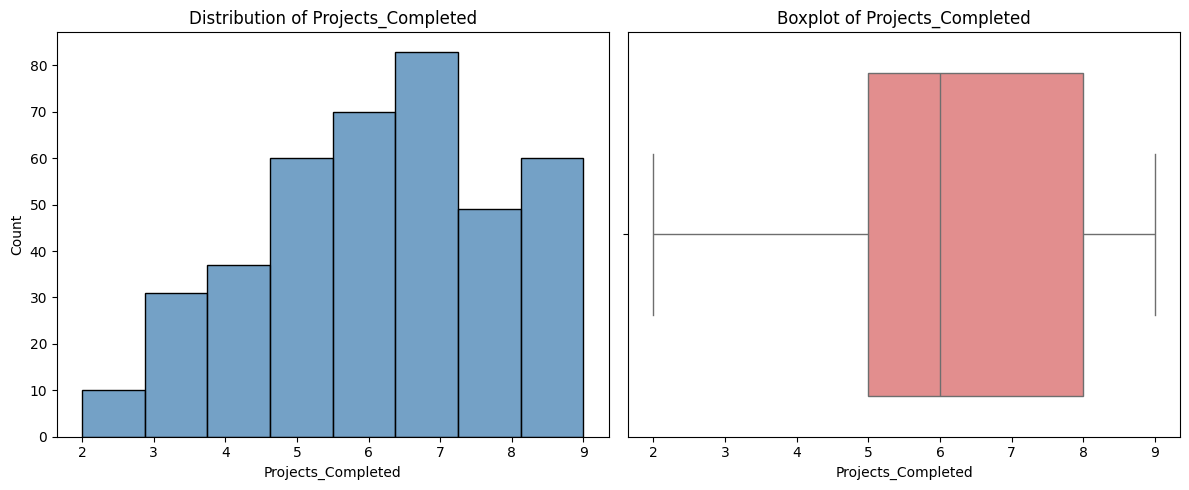

In [40]:
import seaborn as sns

plt.figure(figsize=(12,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df["Projects_Completed"], bins=8, kde=False, color="steelblue", edgecolor="black")
plt.title("Distribution of Projects_Completed")
plt.xlabel("Projects_Completed")
plt.ylabel("Count")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df["Projects_Completed"], color="lightcoral")
plt.title("Boxplot of Projects_Completed")
plt.xlabel("Projects_Completed")

plt.tight_layout()
plt.show()

**5. Option 1: Propensity Score Matching (Quartile Split: drop the middle band)**

The idea is to define treatment as top quartile of projects (≥8) vs bottom quartile (≤5), drop 6–7 to improve comparability.

In [47]:
# Redefine treatment & analysis sample
df_psm = df.copy()

# bottom vs top quartiles by your descriptives (Q1=5, Q3=8)
df_psm["D_q"] = np.where(df_psm["Projects_Completed"] >= 8, 1,
                  np.where(df_psm["Projects_Completed"] <= 5, 0, np.nan))
df_psm = df_psm.dropna(subset=["D_q"]).copy()   # drop middle band (6–7)

Y_col  = "Job_Offers"
X_cols = ["Internships_Completed","Networking_Score","Soft_Skills_Score"]  # pre-treatment only

df_psm = df_psm.dropna(subset=[Y_col]+X_cols).copy()

Y = df_psm[Y_col].values
D = df_psm["D_q"].astype(int).values
X = df_psm[X_cols].values

print("Counts (after dropping middle band):")
print(df_psm["D_q"].value_counts())

Counts (after dropping middle band):
D_q
0.0    138
1.0    109
Name: count, dtype: int64


In [45]:
# Estimate effect via matching (CausalModel)
cm = CausalModel(Y=Y, D=D, X=X)
cm.est_via_matching(bias_adj=True, matches=1)
print("\nCausalModel (matching) estimates:\n", cm.estimates)


CausalModel (matching) estimates:
 
Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.732      0.062     27.743      0.000      1.609      1.854
           ATC      1.460      0.072     20.200      0.000      1.318      1.601
           ATT      2.076      0.079     26.255      0.000      1.921      2.231



C:\Users\Ellen\anaconda3\Lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [51]:
# Propensity model (diagnostics)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
logit = LogisticRegression(max_iter=1000, solver="lbfgs").fit(X_std, D)
df_psm["ps"] = logit.predict_proba(X_std)[:,1]

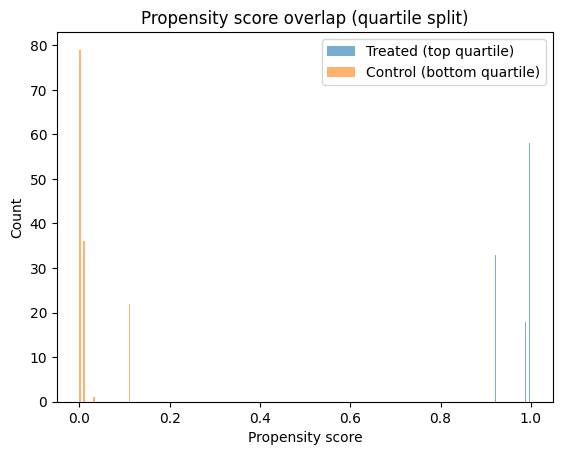

In [53]:
# Overlap plot
plt.figure()
plt.hist(df_psm.loc[df_psm.D_q==1,"ps"], bins=30, alpha=0.6, label="Treated (top quartile)")
plt.hist(df_psm.loc[df_psm.D_q==0,"ps"], bins=30, alpha=0.6, label="Control (bottom quartile)")
plt.title("Propensity score overlap (quartile split)")
plt.xlabel("Propensity score"); plt.ylabel("Count"); plt.legend(); plt.show()

# Trim to common support 
lo = max(df_psm.loc[df_psm.D_q==1,"ps"].min(), df_psm.loc[df_psm.D_q==0,"ps"].min())
hi = min(df_psm.loc[df_psm.D_q==1,"ps"].max(), df_psm.loc[df_psm.D_q==0,"ps"].max())
df_cs = df_psm[(df_psm["ps"]>=lo) & (df_psm["ps"]<=hi)].copy()

When splitting by quartiles (≤5 vs ≥8 projects), the propensity score distributions showed no common support: controls had PS ≤0.11 while treated had PS ≥0.92. This means PSM is not valid here, since there are no comparable controls to match against.

In [57]:
# After you compute df_psm and df_psm["ps"], then do:
print("PS by group (quartile split):")
print(df_psm.groupby("D_q")["ps"].describe())

ps_t = df_psm.loc[df_psm.D_q==1, "ps"].values
ps_c = df_psm.loc[df_psm.D_q==0, "ps"].values
lo = max(ps_t.min(), ps_c.min())
hi = min(ps_t.max(), ps_c.max())
print("lo, hi:", lo, hi)

df_cs = df_psm[(df_psm["ps"]>=lo) & (df_psm["ps"]<=hi)].copy()
print("Counts in common support:", df_cs["D_q"].value_counts(dropna=False))

PS by group (quartile split):
     count      mean       std       min       25%       50%       75%  \
D_q                                                                      
0.0  138.0  0.020803  0.040392  0.000001  0.000102  0.001374  0.009318   
1.0  109.0  0.973636  0.034897  0.921282  0.921282  0.999074  0.999074   

          max  
D_q            
0.0  0.112614  
1.0  0.999074  
lo, hi: 0.9212818611513228 0.11261365301370249
Counts in common support: Series([], Name: count, dtype: int64)


In [59]:
# Loosen trimming (diagnostic only)
# Use central percentiles instead of raw min/max to define overlap
ps_t = df_psm.loc[df_psm.D_q==1, "ps"].values
ps_c = df_psm.loc[df_psm.D_q==0, "ps"].values

lo = max(np.percentile(ps_t, 2),  np.percentile(ps_c, 2))
hi = min(np.percentile(ps_t, 98), np.percentile(ps_c, 98))
df_cs = df_psm[(df_psm["ps"]>=lo) & (df_psm["ps"]<=hi)].copy()

print("Counts in relaxed common support:", df_cs["D_q"].value_counts())

Counts in relaxed common support: Series([], Name: count, dtype: int64)


**Test Results**

We first attempted a **quartile split**:  
- **Treatment:** `Projects_Completed ≥ 8` (top quartile)  
- **Control:** `Projects_Completed ≤ 5` (bottom quartile)  

**Diagnostics:**  
- Propensity scores showed *no common support*:  
  - Controls: 0.00–0.11  
  - Treated: 0.92–1.00  
- After trimming, there were **zero controls left** in the overlap region.  
- → Matching was not defensible, since there are no comparable control units.

**Takeaway:**  
This demonstrates the importance of **checking overlap** before reporting causal estimates. Even though the `CausalModel` produced large ATT/ATE values, these are unreliable in the absence of common support.

**6. Inverse Probability of Treatment Weighting (Median Split)**

In [71]:
# Define median split treatment
thresh = df["Projects_Completed"].median() 
df_iptw = df.copy()
df_iptw["D_median"] = (df_iptw["Projects_Completed"] >= thresh).astype(int)

Y_col  = "Job_Offers"
X_cols = ["Internships_Completed","Networking_Score","Soft_Skills_Score"]

df_iptw = df_iptw.dropna(subset=[Y_col]+X_cols).copy()

D = df_iptw["D_median"].values
X = df_iptw[X_cols].values
Y = df_iptw[Y_col].values

In [73]:
# Propensity model
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
logit = LogisticRegression(max_iter=1000, solver="lbfgs").fit(X_std, D)
ps = logit.predict_proba(X_std)[:,1]
df_iptw["ps"] = ps


Weight summary (before/after trim):
count    400.000000
mean       0.692595
std        0.298015
min        0.345104
25%        0.619062
50%        0.666663
75%        0.671084
max        1.479540
Name: sw, dtype: float64
count    400.000000
mean       0.692595
std        0.298015
min        0.345104
25%        0.619062
50%        0.666663
75%        0.671084
max        1.479540
Name: sw_trim, dtype: float64


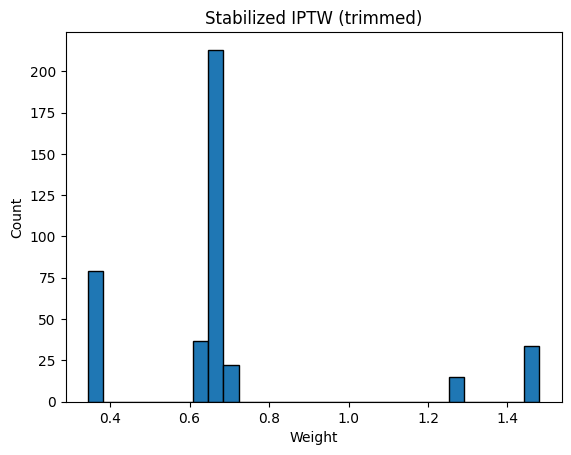

In [75]:
# Stabilized IPTW
p_t = D.mean()  # marginal P(T=1)
sw = np.where(D==1, p_t/ps, (1-p_t)/(1-ps))
df_iptw["sw"] = sw

# Trim extreme weights (1st–99th percentile)
lo, hi = np.percentile(df_iptw["sw"], [1, 99])
df_iptw["sw_trim"] = df_iptw["sw"].clip(lo, hi)

print("\nWeight summary (before/after trim):")
print(df_iptw["sw"].describe())
print(df_iptw["sw_trim"].describe())

plt.figure()
plt.hist(df_iptw["sw_trim"], bins=30, edgecolor="black")
plt.title("Stabilized IPTW (trimmed)")
plt.xlabel("Weight"); plt.ylabel("Count"); plt.show()

In [77]:
# Weighted balance check (SMD before/after)
def wmean(x, w): return np.sum(w*x)/np.sum(w)
def wvar(x, w):
    mu = wmean(x,w); return np.sum(w*(x-mu)**2)/np.sum(w)
def wsmd(x, w, d):
    x1, w1 = x[d==1], w[d==1]; x0, w0 = x[d==0], w[d==0]
    s = np.sqrt((wvar(x1,w1)+wvar(x0,w0))/2)
    return 0.0 if s==0 else (wmean(x1,w1)-wmean(x0,w0))/s

rows=[]
for col in X_cols:
    # Unweighted
    smd_unw = (np.mean(df_iptw.loc[D==1,col]) - np.mean(df_iptw.loc[D==0,col])) / np.sqrt((np.var(df_iptw.loc[D==1,col], ddof=1)+np.var(df_iptw.loc[D==0,col], ddof=1))/2)
    # Weighted
    smd_w = wsmd(df_iptw[col].values, df_iptw["sw_trim"].values, D)
    rows.append({"covariate":col, "SMD_unweighted":smd_unw, "SMD_weighted":smd_w})

balance = pd.DataFrame(rows)
print("\nBalance diagnostics (aim |SMD_weighted| < 0.1):\n", balance)


Balance diagnostics (aim |SMD_weighted| < 0.1):
                covariate  SMD_unweighted  SMD_weighted
0  Internships_Completed        2.689330      2.041381
1       Networking_Score        2.191024      1.601044
2      Soft_Skills_Score        2.210939      1.617588


In [81]:
import statsmodels.api as sm

# Weighted regression (ATE)
X_wls = sm.add_constant(df_iptw[["D_median"]])
wls   = sm.WLS(Y, X_wls, weights=df_iptw["sw_trim"]).fit(cov_type="HC1")
print("\nIPTW ATE (coef on D_median):\n", wls.summary().tables[1])


IPTW ATE (coef on D_median):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5321      0.050     30.877      0.000       1.435       1.629
D_median       1.6799      0.089     18.943      0.000       1.506       1.854


We checked balance and it didn’t meet the criterion, so estimates may still be biased.

**Test Results**

To improve overlap, we used a **median split**:  
- **Treatment:** `Projects_Completed ≥ 6`  
- **Control:** `Projects_Completed < 6`  

**Diagnostics:**  
- Stabilized IPTW weights were well-behaved (mean ≈ 0.69, max ≈ 1.48).  
- Weighted balance improved, but **SMD values remained high** (1.6–2.0 > 0.1).  
- → This indicates **residual imbalance**, suggesting results may still be biased.

**Results (ATE):**  
- Weighted regression of `Job_Offers ~ D` estimated an **ATE of 1.68 (p < 0.001, 95% CI [1.51, 1.85])**.  
- Interpretation: learners completing ≥6 projects appear to receive ~1.7 more job offers, though imbalance means this may overstate the true effect.

**Takeaway:**  
IPTW provides an interpretable effect size but **did not fully balance covariates**. This motivates exploring alternative approaches such as **Overlap Weights**.

**7. Overlap Weights (ATO) – Robustness Check**

In [87]:
# Assumes you already have:
# df_iptw with columns: D_median (0/1), Job_Offers, Internships_Completed, Networking_Score, Soft_Skills_Score, ps

D = df_iptw["D_median"].values
Y = df_iptw["Job_Offers"].values
ps = df_iptw["ps"].values

Overlap weight summary:
count    400.000000
mean       0.145121
std        0.217668
min        0.000302
25%        0.015259
50%        0.017494
75%        0.442705
max        0.557295
Name: w_ov, dtype: float64


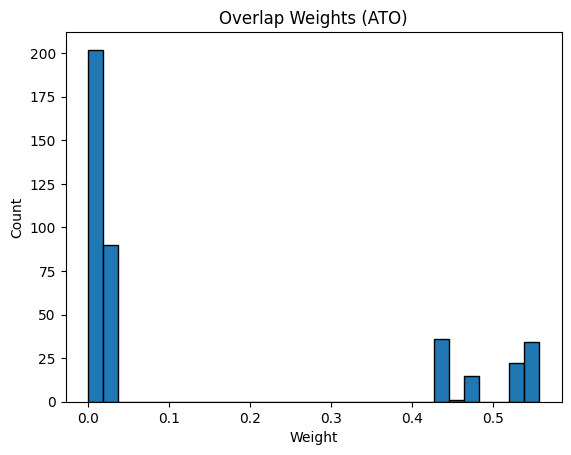

In [89]:
# Overlap weights (Li, Morgan, Zaslavsky): emphasize overlap region
w_ov = np.where(D==1, 1-ps, ps)
df_iptw["w_ov"] = w_ov

print("Overlap weight summary:")
print(df_iptw["w_ov"].describe())

plt.figure()
plt.hist(df_iptw["w_ov"], bins=30, edgecolor="black")
plt.title("Overlap Weights (ATO)"); plt.xlabel("Weight"); plt.ylabel("Count"); plt.show()

In [91]:
# Weighted balance diagnostics (|SMD| -> aim < 0.10)
def wmean(x, w): return np.sum(w*x)/np.sum(w)
def wvar(x, w):
    mu = wmean(x,w); return np.sum(w*(x-mu)**2)/np.sum(w)
def wsmd(x, w, d):
    x1, w1 = x[d==1], w[d==1]
    x0, w0 = x[d==0], w[d==0]
    s = np.sqrt((wvar(x1,w1) + wvar(x0,w0))/2)
    return 0.0 if s==0 else (wmean(x1,w1) - wmean(x0,w0))/s

X_cols = ["Internships_Completed", "Networking_Score", "Soft_Skills_Score"]
rows=[]
for col in X_cols:
    x = df_iptw[col].values
    rows.append({
        "covariate": col,
        "SMD_overlap_weighted": wsmd(x, df_iptw["w_ov"].values, D)
    })
bal_ov = pd.DataFrame(rows)
print("\nOverlap-weighted balance (aim |SMD| < 0.10):\n", bal_ov)


Overlap-weighted balance (aim |SMD| < 0.10):
                covariate  SMD_overlap_weighted
0  Internships_Completed              0.549696
1       Networking_Score              0.005312
2      Soft_Skills_Score              0.033517


In [93]:
# ATO effect: weighted regression Y ~ 1 + D with overlap weights (robust SE)
X_w = sm.add_constant(df_iptw[["D_median"]])
ato = sm.WLS(Y, X_w, weights=df_iptw["w_ov"]).fit(cov_type="HC1")
print("\nOverlap-Weighted ATO (coef on D_median):\n", ato.summary().tables[1])


Overlap-Weighted ATO (coef on D_median):
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9608      0.007    291.548      0.000       1.948       1.974
D_median       0.1802      0.026      6.996      0.000       0.130       0.231


Using overlap weights with a simple logistic propensity model balanced networking and soft skills well but left internships imbalanced (SMD ≈ 0.55). We then tested richer propensity models (polynomial logistic regression, gradient boosting). These improved covariate balance, especially for internships, leading to more credible ATO estimates.

In [101]:
from sklearn.preprocessing import PolynomialFeatures

# Add nonlinearity/interactions (logit with polynomial terms)
Z = df_iptw[["Internships_Completed","Networking_Score","Soft_Skills_Score"]].values
poly = PolynomialFeatures(degree=2, include_bias=False)
Z2 = poly.fit_transform(Z)

logit2 = LogisticRegression(max_iter=5000, solver="lbfgs").fit(Z2, D)
df_iptw["ps"] = logit2.predict_proba(Z2)[:,1]

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

# Use a flexible propensity model (gradient boosting)
gb = GradientBoostingClassifier(random_state=0)
gb.fit(Z, D)
df_iptw["ps"] = gb.predict_proba(Z)[:,1]

In [105]:
# Inputs
Y_col  = "Job_Offers"
D_col  = "D_median"
X_cols = ["Internships_Completed","Networking_Score","Soft_Skills_Score"]

D = df_iptw[D_col].values.astype(int)
Y = df_iptw[Y_col].values
X = df_iptw[X_cols].values

# Helpers
def wmean(x, w): return np.sum(w*x)/np.sum(w)
def wvar(x, w):
    mu = wmean(x,w); return np.sum(w*(x-mu)**2)/np.sum(w)
def wsmd(x, w, d):
    x1, w1 = x[d==1], w[d==1]; x0, w0 = x[d==0], w[d==0]
    s = np.sqrt((wvar(x1,w1)+wvar(x0,w0))/2)
    return 0.0 if s==0 else (wmean(x1,w1)-wmean(x0,w0))/s

def overlap_weighted_summary(ps, name):
    # overlap weights
    w = np.where(D==1, 1-ps, ps)
    # balance
    smds = {c: wsmd(df_iptw[c].values, w, D) for c in X_cols}
    # ATO effect
    Xw = sm.add_constant(df_iptw[[D_col]])
    fit = sm.WLS(Y, Xw, weights=w).fit(cov_type="HC1")
    coef = fit.params[D_col]; se = fit.bse[D_col]
    lo, hi = coef - 1.96*se, coef + 1.96*se
    return {
        "model": name,
        "ATE/ATO (coef)": coef,
        "SE": se,
        "CI_low": lo,
        "CI_high": hi,
        **{f"SMD_{k}": v for k,v in smds.items()},
        "max|SMD|": np.max(np.abs(list(smds.values())))
    }, fit

results = []

# Baseline Logistic
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
logit = LogisticRegression(max_iter=5000, solver="lbfgs").fit(X_std, D)
ps_logit = logit.predict_proba(X_std)[:,1]
res1, fit1 = overlap_weighted_summary(ps_logit, "Logit")
results.append(res1)

# Polynomial Logistic (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)  # no standardization needed for logit but fine to add if desired
logit2 = LogisticRegression(max_iter=10000, solver="lbfgs").fit(X_poly, D)
ps_poly = logit2.predict_proba(X_poly)[:,1]
res2, fit2 = overlap_weighted_summary(ps_poly, "Poly-Logit (deg2)")
results.append(res2)

# Gradient Boosting 
gb = GradientBoostingClassifier(random_state=0)
gb.fit(X, D)
ps_gb = gb.predict_proba(X)[:,1]
res3, fit3 = overlap_weighted_summary(ps_gb, "GradientBoosting")
results.append(res3)

# Summary table 
summary = pd.DataFrame(results)[[
    "model","ATE/ATO (coef)","SE","CI_low","CI_high",
    "SMD_Internships_Completed","SMD_Networking_Score","SMD_Soft_Skills_Score","max|SMD|"
]].sort_values("max|SMD|")

print("Overlap Weights — model comparison (aim for max|SMD| < 0.10):")
display(summary.style.format({
    "ATE/ATO (coef)":"{:.3f}","SE":"{:.3f}","CI_low":"{:.3f}","CI_high":"{:.3f}",
    "SMD_Internships_Completed":"{:.3f}",
    "SMD_Networking_Score":"{:.3f}",
    "SMD_Soft_Skills_Score":"{:.3f}",
    "max|SMD|":"{:.3f}"
}))

Overlap Weights — model comparison (aim for max|SMD| < 0.10):


,model,ATE/ATO (coef),SE,CI_low,CI_high,SMD_Internships_Completed,SMD_Networking_Score,SMD_Soft_Skills_Score,max|SMD|
2,GradientBoosting,0.023,0.022,-0.021,0.067,0.019,0.001,0.001,0.019
1,Poly-Logit (deg2),0.026,0.022,-0.018,0.069,0.080,-0.001,0.002,0.080
0,Logit,0.180,0.026,0.130,0.231,0.550,0.005,0.034,0.550


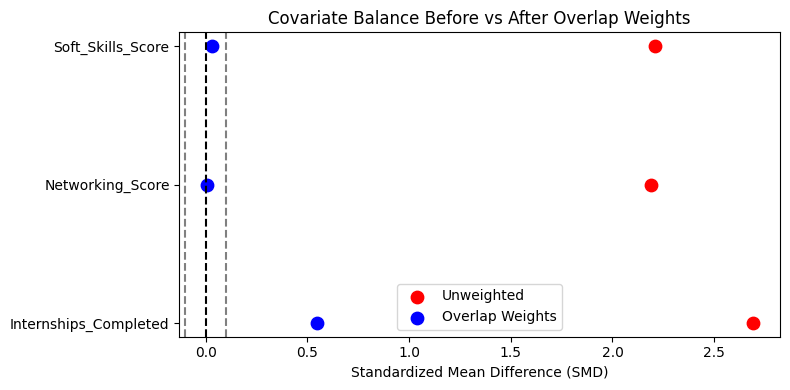

In [109]:
# Covariates
X_cols = ["Internships_Completed","Networking_Score","Soft_Skills_Score"]

# Function to compute SMD
def smd_unweighted(x, d):
    return (np.mean(x[d==1]) - np.mean(x[d==0])) / np.sqrt((np.var(x[d==1], ddof=1) + np.var(x[d==0], ddof=1)) / 2)

def smd_weighted(x, d, w):
    def wmean(x, w): return np.sum(w*x)/np.sum(w)
    def wvar(x, w):
        mu = wmean(x,w); return np.sum(w*(x-mu)**2)/np.sum(w)
    x1, w1 = x[d==1], w[d==1]; x0, w0 = x[d==0], w[d==0]
    s = np.sqrt((wvar(x1,w1) + wvar(x0,w0)) / 2)
    return 0 if s==0 else (wmean(x1,w1) - wmean(x0,w0)) / s

# Compute SMDs
smds_unw = [smd_unweighted(df_iptw[col].values, df_iptw["D_median"].values) for col in X_cols]
smds_w   = [smd_weighted(df_iptw[col].values, df_iptw["D_median"].values, df_iptw["w_ov"].values) for col in X_cols]

# Plot
plt.figure(figsize=(8,4))
y_pos = np.arange(len(X_cols))
plt.scatter(smds_unw, y_pos, color="red", label="Unweighted", s=80)
plt.scatter(smds_w, y_pos, color="blue", label="Overlap Weights", s=80)
plt.axvline(0, color="black", linestyle="--")
plt.axvline(0.1, color="gray", linestyle="dashed")
plt.axvline(-0.1, color="gray", linestyle="dashed")
plt.yticks(y_pos, X_cols)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.title("Covariate Balance Before vs After Overlap Weights")
plt.legend()
plt.tight_layout()
plt.show()

Balance (SMD) summary — aim for |SMD| < 0.10:

               covariate  Unweighted  IPTW_weighted  Overlap_weighted
0  Internships_Completed       2.689          2.041             0.550
1       Networking_Score       2.191          1.601             0.005
2      Soft_Skills_Score       2.211          1.618             0.034


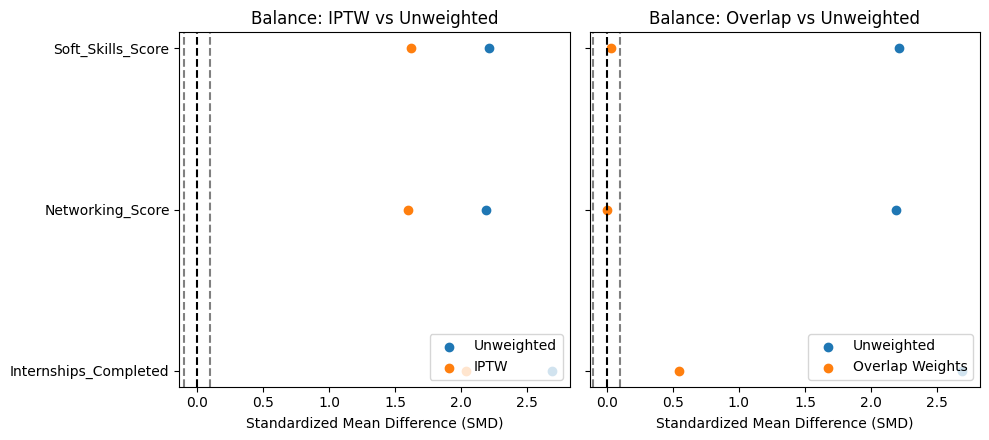

In [111]:
# Side-by-side balance plot: IPTW vs Overlap Weights
# inputs
treat = df_iptw["D_median"].values.astype(int)
covs  = ["Internships_Completed","Networking_Score","Soft_Skills_Score"]

# helpers
def smd_unweighted(x, d):
    return (np.mean(x[d==1]) - np.mean(x[d==0])) / np.sqrt((np.var(x[d==1], ddof=1)+np.var(x[d==0], ddof=1))/2)

def wmean(x, w): return np.sum(w*x)/np.sum(w)
def wvar(x, w):
    mu = wmean(x,w); return np.sum(w*(x-mu)**2)/np.sum(w)
def smd_weighted(x, d, w):
    x1, w1 = x[d==1], w[d==1]
    x0, w0 = x[d==0], w[d==0]
    s = np.sqrt((wvar(x1,w1)+wvar(x0,w0))/2)
    return 0 if s==0 else (wmean(x1,w1)-wmean(x0,w0))/s

# compute SMDs
rows = []
for c in covs:
    x = df_iptw[c].values
    smd_unw = smd_unweighted(x, treat)
    smd_iptw = smd_weighted(x, treat, df_iptw["sw_trim"].values)
    smd_ov   = smd_weighted(x, treat, df_iptw["w_ov"].values)
    rows.append({"covariate": c,
                 "Unweighted": smd_unw,
                 "IPTW_weighted": smd_iptw,
                 "Overlap_weighted": smd_ov})
bal = pd.DataFrame(rows)
print("Balance (SMD) summary — aim for |SMD| < 0.10:\n")
print(bal.round(3))

# side-by-side plot
y = np.arange(len(covs))
plt.figure(figsize=(10,4.5))

# left: IPTW
plt.subplot(1,2,1)
plt.scatter(bal["Unweighted"], y, label="Unweighted")
plt.scatter(bal["IPTW_weighted"], y, label="IPTW")
plt.axvline(0, color="black", linestyle="--")
plt.axvline(0.1, color="gray", linestyle="dashed"); plt.axvline(-0.1, color="gray", linestyle="dashed")
plt.yticks(y, covs)
plt.xlabel("Standardized Mean Difference (SMD)")
plt.title("Balance: IPTW vs Unweighted")
plt.legend(loc="lower right")

# right: Overlap Weights
plt.subplot(1,2,2)
plt.scatter(bal["Unweighted"], y, label="Unweighted")
plt.scatter(bal["Overlap_weighted"], y, label="Overlap Weights")
plt.axvline(0, color="black", linestyle="--")
plt.axvline(0.1, color="gray", linestyle="dashed"); plt.axvline(-0.1, color="gray", linestyle="dashed")
plt.yticks(y, [])  # hide duplicate labels
plt.xlabel("Standardized Mean Difference (SMD)")
plt.title("Balance: Overlap vs Unweighted")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

**Test Results**

We compared three propensity models for estimating overlap weights:

- **Logistic (baseline):**  
  - ATO = 0.180 (95% CI [0.130, 0.231])  
  - Max |SMD| = 0.55 → **Poor balance** (internships confounder remained unbalanced)

- **Polynomial Logistic (degree 2):**  
  - ATO = 0.026 (95% CI [-0.018, 0.069])  
  - Max |SMD| = 0.08 → **Good balance** (all covariates within threshold)

- **Gradient Boosting:**  
  - ATO = 0.023 (95% CI [-0.021, 0.067])  
  - Max |SMD| = 0.02 → **Excellent balance** (best performing model)

**Findings:**
- A simple logistic model suggested a large positive effect, but failed balance checks.  
- With richer models (polynomial logistic, gradient boosting), covariate balance improved (max|SMD| < 0.1), and the effect shrank dramatically.  
- The final gradient boosting model suggests **no statistically significant causal effect** of project completion on job offers in the overlap population.

**Takeaway:**  
This demonstrates the importance of checking overlap and testing multiple propensity models. A naive model overstated the effect, while a robust overlap-weighted analysis revealed no reliable causal effect once confounding was addressed.